In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/movies.csv
/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/ratings.csv
/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/genome-tags.csv
/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/README.txt
/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/genome-scores.csv
/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/tags.csv
/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/links.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [4]:
df_rating = pd.read_csv("/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/ratings.csv")
df_rating = df_rating[df_rating["userId"].isin(np.arange(1,301))]
df_rating.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
df_movie = pd.read_csv("/kaggle/input/movielens-full-25-million-recommendation-data/ml-25m/movies.csv")
df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


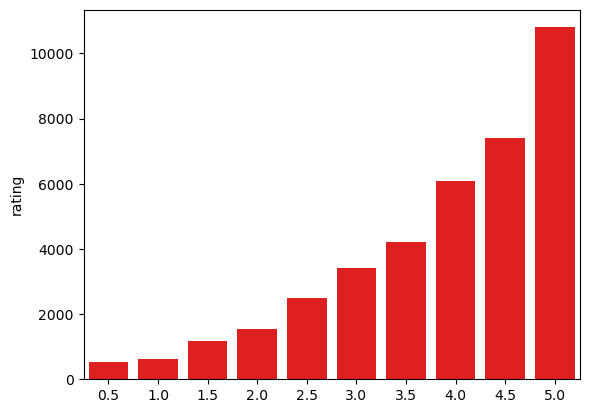

In [6]:
rankings_count = df_rating.rating.value_counts().sort_values()
sns.barplot(x=rankings_count.index.sort_values(), y=rankings_count, color="r")
sns.set_theme(style="white")

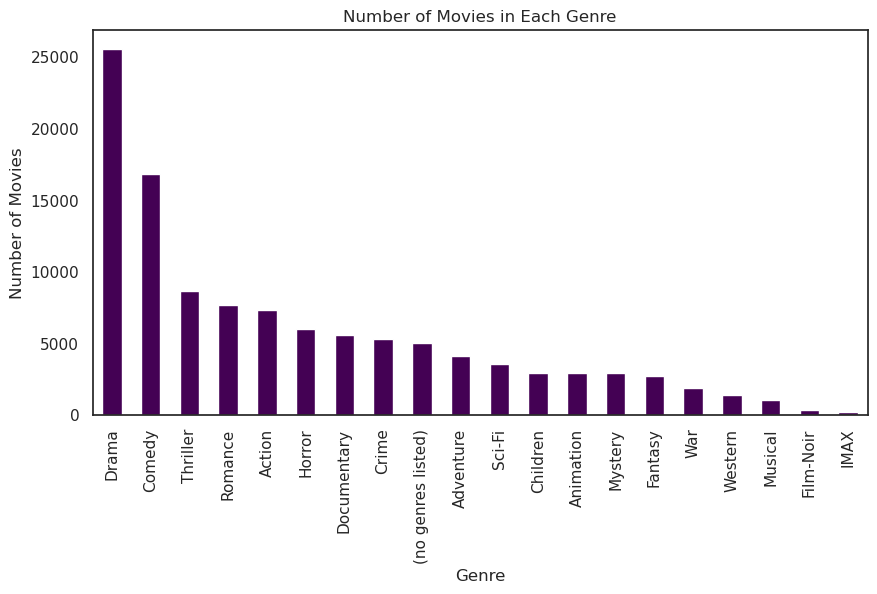

In [7]:
data_movie = df_movie.copy()
# data_movie.head()

data_movie['genres'] = data_movie['genres'].str.split('|')
genres_df = data_movie.explode('genres')
genre_counts = genres_df['genres'].value_counts()
# data_movie.head()

genre_counts.plot(kind='bar', figsize=(10,5), colormap='viridis')
plt.title('Number of Movies in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.show()

In [8]:
merged_df = pd.merge(df_rating, df_movie, on='movieId')

mean_ratings = merged_df.groupby('title')['rating'].mean()

top_20 = mean_ratings.sort_values(ascending=True).head(20)
top_20


title
United 93 (2006)                              0.5
Bad News Bears Go to Japan, The (1978)        0.5
Hobson's Choice (1954)                        0.5
Down with Love (2003)                         0.5
Follow Me, Boys! (1966)                       0.5
Fame (2009)                                   0.5
The Emoji Movie (2017)                        0.5
T-Rex: Back to the Cretaceous (1998)          0.5
Swimfan (2002)                                0.5
Manos: The Hands of Fate (1966)               0.5
Faces of Death: Fact or Fiction? (1999)       0.5
Faces of Death 5 (1996)                       0.5
The Wailing (2016)                            0.5
Faces of Death 3 (1985)                       0.5
Girls, Les (1957)                             0.5
Forgotten, The (2004)                         0.5
Vanishing, The (Spoorloos) (1988)             0.5
Chorus Line, A (1985)                         0.5
Barbie as The Princess & the Pauper (2004)    0.5
Barbie: The Princess & The Popstar (2012)   

In [9]:
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


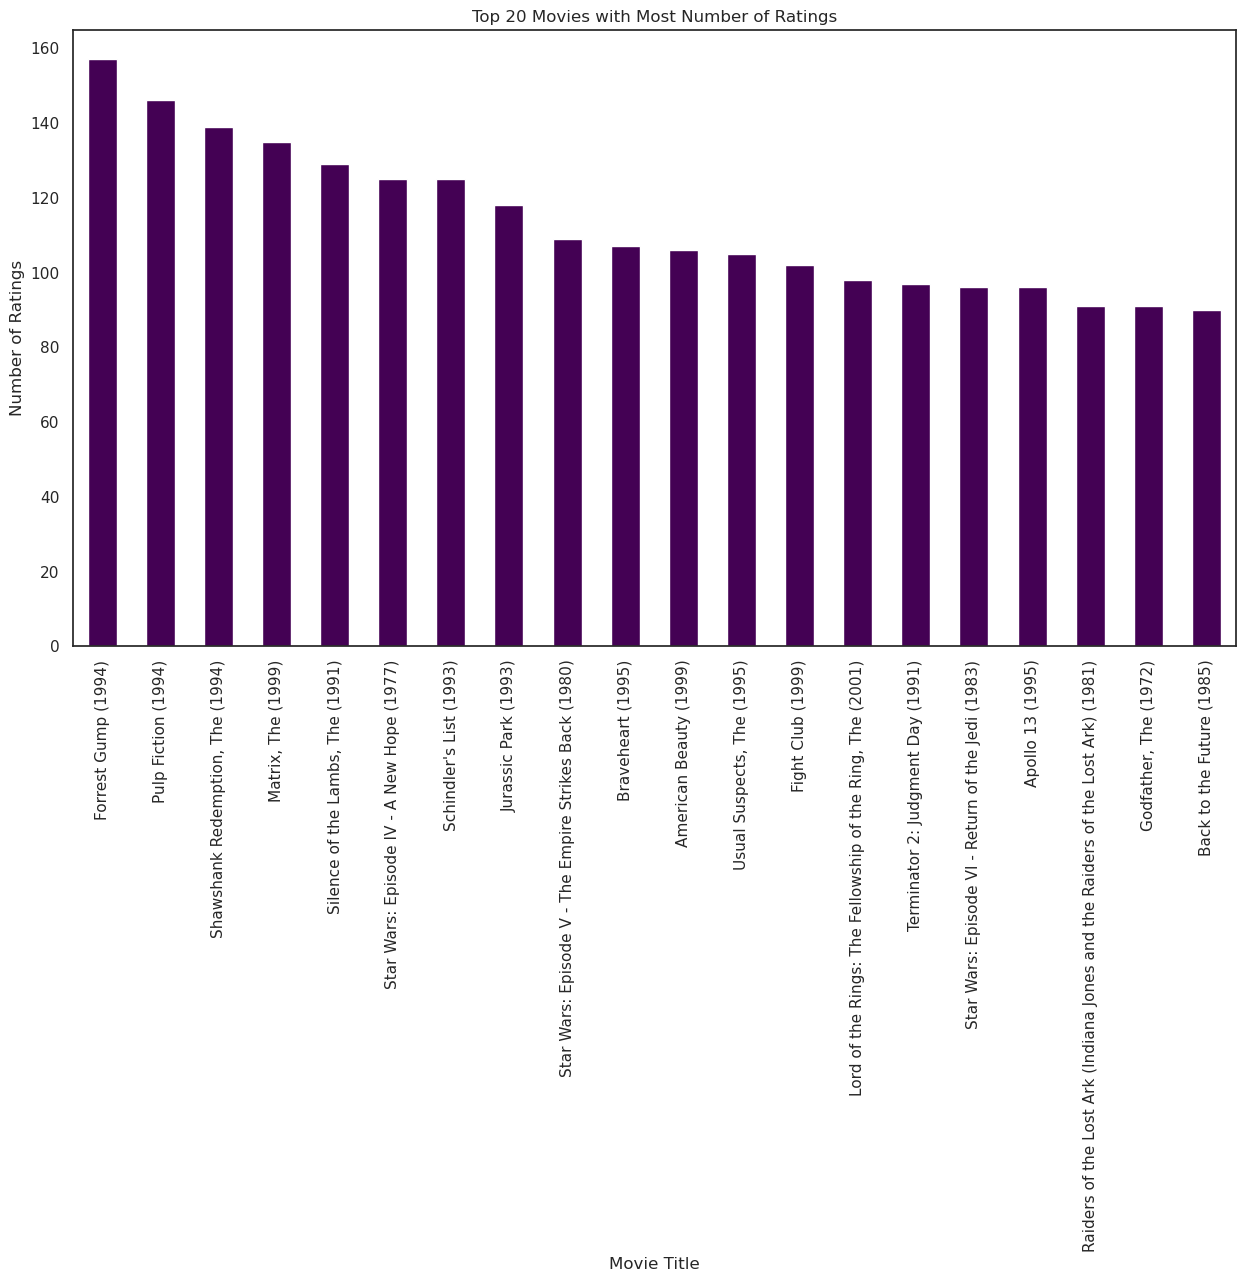

In [10]:
rating_counts = merged_df.groupby('title')['rating'].count()

top_20 = rating_counts.sort_values(ascending=False).head(20)

top_20.plot(kind='bar',figsize=(15,8), colormap = 'viridis')
plt.title('Top 20 Movies with Most Number of Ratings')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.show()

In [11]:
df_ratings = df_rating.dropna()

df_ratings['timestamp'] = pd. to_datetime(df_ratings['timestamp'], unit='s')

print(f'unique users: {len(df_ratings.userId.unique())}, ratings: {len(df_ratings)}')
df_ratings.head()

unique users: 300, ratings: 38327


,userId,movieId,rating,timestamp
0,1,296,5.0,2006-05-17 15:34:04
1,1,306,3.5,2006-05-17 12:26:57
2,1,307,5.0,2006-05-17 12:27:08
3,1,665,5.0,2006-05-17 15:13:40
4,1,899,3.5,2006-05-17 12:21:50


In [12]:
from surprise import Reader, SVD, Dataset, KNNBasic, accuracy
from surprise.model_selection import train_test_split, cross_validate
reader = Reader()
users_ratings = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

train_df, test_df = train_test_split(users_ratings, test_size=.2)

# KNN

In [13]:
# Use the KNNBasic algorithm to train the model
knn_model = KNNBasic()
knn_model_trained = knn_model.fit(train_df)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [16]:
cross_val_results_knn = cross_validate(knn_model_trained, users_ratings, measures=['RMSE', 'MAE', 'MSE'], cv=10, verbose=False)
test_mae_knn = cross_val_results_knn['test_mae']

df_test_mae_knn = pd.DataFrame(test_mae_knn, columns=['Mean Absolute Error'])
df_test_mae_knn.index = np.arange(1, len(df_test_mae_knn) + 1)
df_test_mae_knn.sort_values(by='Mean Absolute Error', ascending=False)
df_test_mae_knn.head()

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,Mean Absolute Error
1,0.786244
2,0.788178
3,0.782615
4,0.775443
5,0.784126


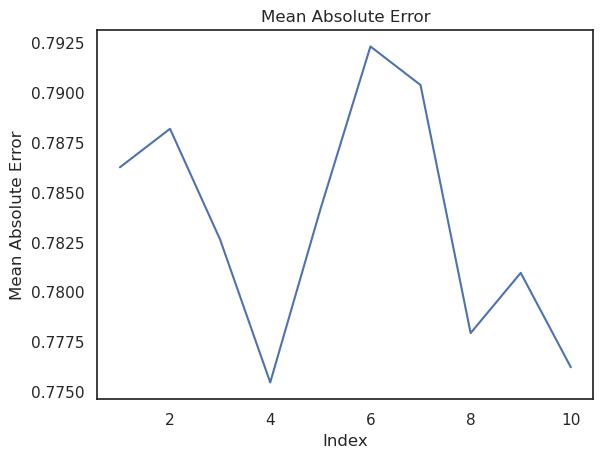

In [17]:
plt.plot(df_test_mae_knn['Mean Absolute Error'])
plt.title('Mean Absolute Error')
plt.xlabel('Index')
plt.ylabel('Mean Absolute Error')
plt.show()

In [18]:
user_id = 400 

pred_series= []
df_ratings_filtered = df_rating[df_rating['userId'] == user_id]

print(f'number of ratings: {df_ratings_filtered.shape[0]}')
for movie_id, name in zip(df_movie.index, df_movie['title']):
    rating_real = df_rating.query(f'movieId == {movie_id}')['rating'].values[0] if movie_id in df_ratings_filtered['movieId'].values else 0
    rating_pred = knn_model_trained.predict(user_id, movie_id, rating_real, verbose=False)
    pred_series.append([movie_id, name, rating_pred.est, rating_real])

df_recommendations = pd.DataFrame(pred_series, columns=['movieId', 'title', 'predicted_rating', 'actual_rating'])
df_recommendations.sort_values(by='predicted_rating', ascending=False).head(15)

number of ratings: 0


,movieId,title,predicted_rating,actual_rating
0,0,Toy Story (1995),3.582273,0
41636,41636,The Perfect Crime (1978),3.582273,0
41608,41608,3 Days of Normal (2012),3.582273,0
41609,41609,Bubblegum and Broken Fingers (2011),3.582273,0
41610,41610,The Yin and the Yang of Mr. Go (1970),3.582273,0
41611,41611,Spring and Port Wine (1970),3.582273,0
41612,41612,Wedding Day (2012),3.582273,0
41613,41613,Johan Falk: Kodnamn Lisa (2013),3.582273,0
41614,41614,Train to Busan (2016),3.582273,0
41615,41615,Kill! (1971),3.582273,0


In [19]:
predictions = knn_model_trained.test(test_df)

In [20]:
for uid, iid, rating in test_df[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")

User 267 rated item 31410 with a rating of 4.5
User 278 rated item 357 with a rating of 3.0
User 23 rated item 1079 with a rating of 5.0
User 142 rated item 3911 with a rating of 3.5
User 12 rated item 2133 with a rating of 4.0


In [21]:
for prediction in predictions[0:5]:
    print(prediction)

user: 267        item: 31410      r_ui = 4.50   est = 4.01   {'actual_k': 7, 'was_impossible': False}
user: 278        item: 357        r_ui = 3.00   est = 3.51   {'actual_k': 40, 'was_impossible': False}
user: 23         item: 1079       r_ui = 5.00   est = 3.93   {'actual_k': 33, 'was_impossible': False}
user: 142        item: 3911       r_ui = 3.50   est = 3.86   {'actual_k': 22, 'was_impossible': False}
user: 12         item: 2133       r_ui = 4.00   est = 3.49   {'actual_k': 5, 'was_impossible': False}


In [22]:
# Print the performance metrics
accuracy.rmse(predictions)

RMSE: 0.7362


0.7362173059115643

In [23]:
true_ratings = [pred.r_ui for pred in predictions]
est_ratings = [pred.est for pred in predictions]
uids = [pred.uid for pred in predictions]

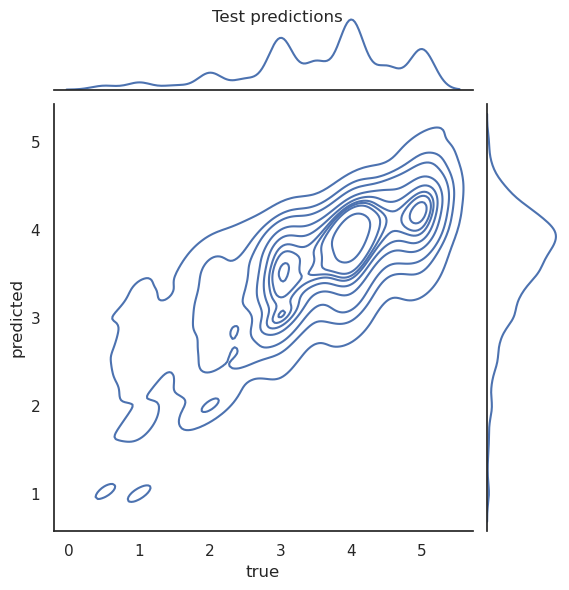

In [24]:
data=pd.DataFrame(columns=["true","predicted"])
data["true"]=true_ratings
data["predicted"]=est_ratings
g = sns.jointplot(data=data,x="true", y="predicted", kind="kde")
g.fig.suptitle('Test predictions',fontsize=12)
plt.show()

# SVD

In [25]:
svd_model = SVD()
svd_model_trained = svd_model.fit(train_df)

In [26]:
cross_val_results_svd = cross_validate(svd_model_trained, users_ratings, measures=['RMSE', 'MAE', 'MSE'], cv=10, verbose=False)
test_mae_svd = cross_val_results_svd['test_mae']

df_test_mae_svd = pd.DataFrame(test_mae_svd, columns=['Mean Absolute Error'])
df_test_mae_svd.index = np.arange(1, len(df_test_mae_svd) + 1)
df_test_mae_svd.sort_values(by='Mean Absolute Error', ascending=False)
df_test_mae_svd.head()

,Mean Absolute Error
1,0.688914
2,0.688915
3,0.667295
4,0.701649
5,0.691023


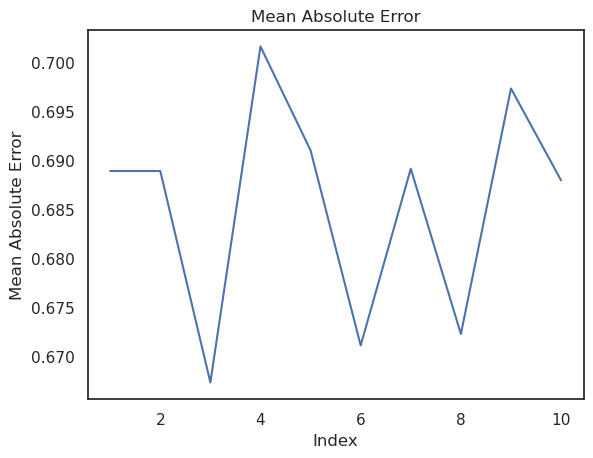

In [27]:
plt.plot(df_test_mae_svd['Mean Absolute Error'])
plt.title('Mean Absolute Error')
plt.xlabel('Index')
plt.ylabel('Mean Absolute Error')
plt.show()

In [28]:
user_id = 400 

pred_series= []
df_ratings_filtered = df_rating[df_rating['userId'] == user_id]

print(f'number of ratings: {df_ratings_filtered.shape[0]}')
for movie_id, name in zip(df_movie.index, df_movie['title']):
    rating_real = df_rating.query(f'movieId == {movie_id}')['rating'].values[0] if movie_id in df_ratings_filtered['movieId'].values else 0
    rating_pred = svd_model_trained.predict(user_id, movie_id, rating_real, verbose=False)
    pred_series.append([movie_id, name, rating_pred.est, rating_real])

df_recommendations = pd.DataFrame(pred_series, columns=['movieId', 'title', 'predicted_rating', 'actual_rating'])
df_recommendations.sort_values(by='predicted_rating', ascending=False).head(15)

number of ratings: 0


,movieId,title,predicted_rating,actual_rating
318,318,Swimming with Sharks (1995),4.524437,0
50,50,Guardian Angel (1994),4.478058,0
1221,1221,"Treasure of the Sierra Madre, The (1948)",4.421537,0
527,527,Serial Mom (1994),4.374217,0
1193,1193,Henry V (1989),4.366186,0
1203,1203,Harold and Maude (1971),4.340631,0
2502,2502,"Monster, The (Mostro, Il) (1994)",4.337361,0
858,858,Girls Town (1996),4.329177,0
593,593,"Wooden Man's Bride, The (Yan shen) (1994)",4.285960,0
44555,44555,The Island (2009),4.272665,0


In [29]:
user_id = 400
movie_id = 4973

movie_title = df_movie[df_movie.index == 2858]['title'].values[0]

query_result = df_rating.query(f'movieId == {movie_id} & userId == {user_id}')
if not query_result.empty:
    rating_real = query_result['rating'].values[0]

print(f'Movie title: {movie_title}')

print(f'Actual rating: {rating_real}')

rating_pred = svd_model_trained.predict(user_id, movie_id, rating_real, verbose=True)

Movie title: Blue Lagoon, The (1980)
Actual rating: 0
user: 400        item: 4973       r_ui = 0.00   est = 4.06   {'was_impossible': False}


In [30]:
predictions_svd = svd_model_trained.test(test_df)

In [31]:
true_ratings = [pred.r_ui for pred in predictions_svd]
est_ratings = [pred.est for pred in predictions_svd]
uids = [pred.uid for pred in predictions_svd]

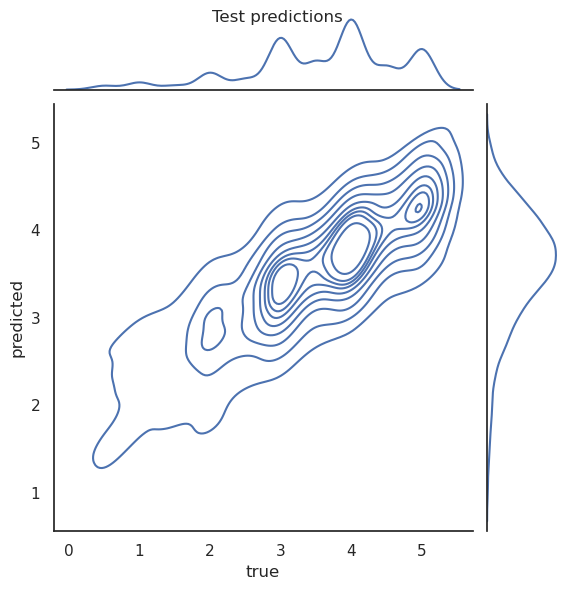

In [32]:
data=pd.DataFrame(columns=["true","predicted"])
data["true"]=true_ratings
data["predicted"]=est_ratings
g = sns.jointplot(data=data,x="true", y="predicted", kind="kde")
g.fig.suptitle('Test predictions',fontsize=12)
plt.show()

In [33]:
# Select only the columns with numerical data types
numerical_columns = df_ratings.select_dtypes(include=[np.number])

numerical_columns.head()


,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


# PCA 

In [35]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Extract the ratings data from the DataFrame
ratings = merged_df.pivot(index='userId', columns='movieId', values='rating')

# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=3)
ratings_pca = pca.fit_transform(numerical_columns)

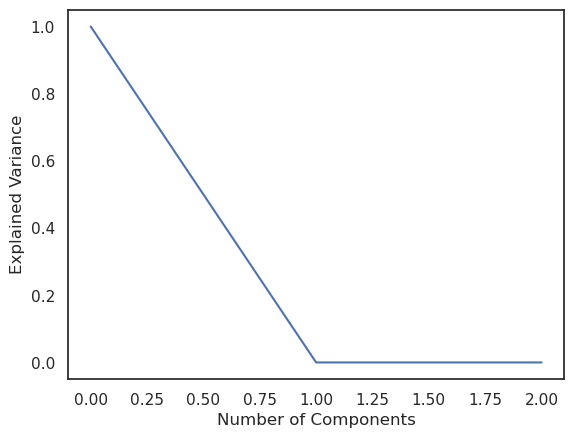

In [36]:
from sklearn.decomposition import PCA

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

In [48]:
numerical_columns

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5
...,...,...,...
38322,300,122886,5.0
38323,300,122892,4.0
38324,300,122900,3.5
38325,300,122904,4.0


In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from surprise.model_selection import train_test_split, cross_validate

In [58]:
reader = Reader()
users_ratings = Dataset.load_from_df(numerical_columns[['userId', 'movieId', 'rating']], reader)

train_df, test_df = train_test_split(users_ratings, test_size=.2)

In [59]:
knn_model = KNNBasic()
knn_model_trained = knn_model.fit(train_df)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [60]:
cross_val_results_knn = cross_validate(knn_model_trained, users_ratings, measures=['RMSE', 'MAE', 'MSE'], cv=10, verbose=False)
test_mae_knn = cross_val_results_knn['test_mae']

df_test_mae_knn = pd.DataFrame(test_mae_knn, columns=['Mean Absolute Error'])
df_test_mae_knn.index = np.arange(1, len(df_test_mae_knn) + 1)
df_test_mae_knn.sort_values(by='Mean Absolute Error', ascending=False)
df_test_mae_knn.head()

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,Mean Absolute Error
1,0.768453
2,0.770307
3,0.786626
4,0.780309
5,0.772430


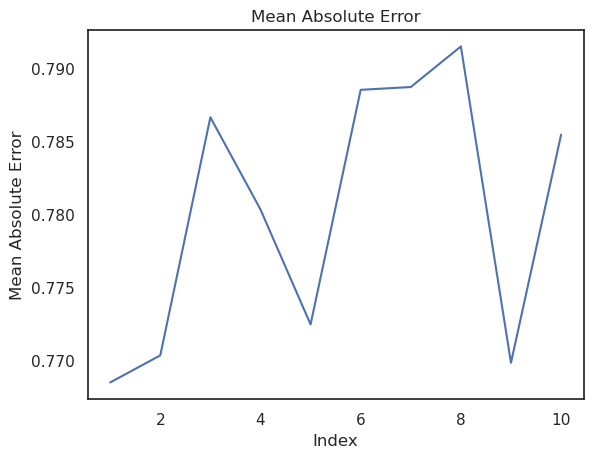

In [61]:
plt.plot(df_test_mae_knn['Mean Absolute Error'])
plt.title('Mean Absolute Error')
plt.xlabel('Index')
plt.ylabel('Mean Absolute Error')
plt.show()

In [62]:
user_id = 400 

pred_series= []
df_ratings_filtered = df_rating[df_rating['userId'] == user_id]

print(f'number of ratings: {df_ratings_filtered.shape[0]}')
for movie_id, name in zip(df_movie.index, df_movie['title']):
    rating_real = df_rating.query(f'movieId == {movie_id}')['rating'].values[0] if movie_id in df_ratings_filtered['movieId'].values else 0
    rating_pred = knn_model_trained.predict(user_id, movie_id, rating_real, verbose=False)
    pred_series.append([movie_id, name, rating_pred.est, rating_real])

df_recommendations = pd.DataFrame(pred_series, columns=['movieId', 'title', 'predicted_rating', 'actual_rating'])
df_recommendations.sort_values(by='predicted_rating', ascending=False).head(15)

number of ratings: 0


,movieId,title,predicted_rating,actual_rating
0,0,Toy Story (1995),3.582519,0
41636,41636,The Perfect Crime (1978),3.582519,0
41608,41608,3 Days of Normal (2012),3.582519,0
41609,41609,Bubblegum and Broken Fingers (2011),3.582519,0
41610,41610,The Yin and the Yang of Mr. Go (1970),3.582519,0
41611,41611,Spring and Port Wine (1970),3.582519,0
41612,41612,Wedding Day (2012),3.582519,0
41613,41613,Johan Falk: Kodnamn Lisa (2013),3.582519,0
41614,41614,Train to Busan (2016),3.582519,0
41615,41615,Kill! (1971),3.582519,0


In [63]:
predictions = knn_model_trained.test(test_df)

In [64]:
true_ratings = [pred.r_ui for pred in predictions]
est_ratings = [pred.est for pred in predictions]
uids = [pred.uid for pred in predictions]

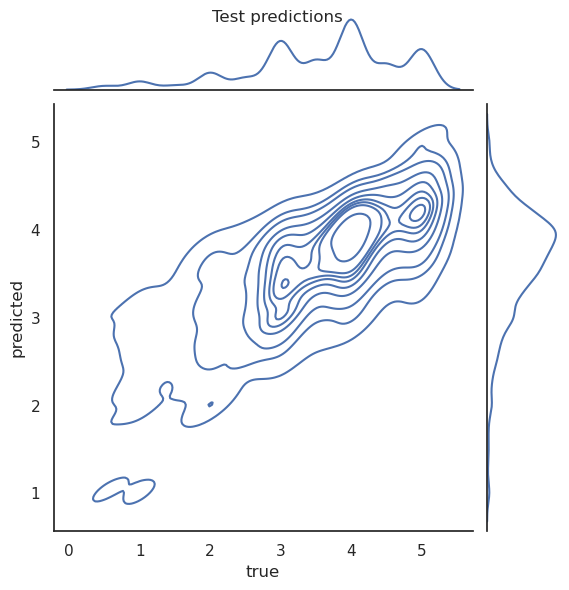

In [65]:
data=pd.DataFrame(columns=["true","predicted"])
data["true"]=true_ratings
data["predicted"]=est_ratings
g = sns.jointplot(data=data,x="true", y="predicted", kind="kde")
g.fig.suptitle('Test predictions',fontsize=12)
plt.show()